Importing Required Libraries

In [21]:
from qiskit.circuit import QuantumCircuit
from qiskit import QuantumCircuit,assemble
from qiskit.compiler import assemble,transpile
from qiskit_aer import Aer
from math import pi, sqrt
import cmath
from qiskit.visualization import plot_bloch_multivector, plot_histogram
sim = Aer.get_backend('aer_simulator')
from qiskit import QuantumRegister, ClassicalRegister
import numpy as np


import warnings
warnings.filterwarnings("ignore")

Packaging Adder Circuit as a Block / Gate

In [20]:
def qft_rotations_iterative(circuit, n,reg):
    for i in range(n):
        circuit.h(reg[n - i - 1])
        for j in range(n - i - 1):
            circuit.cp(np.pi / 2**(i + 1), reg[j], reg[n - i - 1])
    return circuit

def rotation_add(circuit, reg_a, reg_b,  n):

    for i in range(n+1):
        circuit.cp(np.pi / 2**i, reg_b[n - i], reg_a[n ])
    return circuit

def inverse_qft_rotations_iterative(circuit, n,reg):


    for i in range(n):
        for j in range(i):
            circuit.cp(-np.pi / 2**(i - j), reg[j], reg[i])
        circuit.h(reg[i])
    return circuit

def QFT(circuit, n,reg):
    qft_rotations_iterative(circuit,  n,reg)
    return circuit

def IQFT(circuit,n,reg):
    inverse_qft_rotations_iterative(circuit,n,reg)
    return circuit


n = 3


b = QuantumRegister(n,"b")
a = QuantumRegister(n,"a")
qc = QuantumCircuit(b,a)


qc = QFT(qc,n,a)
for i in range(n):
    qc = rotation_add(qc,a,b,i)
qc = IQFT(qc,n,a)


adder_circuit = qc.to_gate().control(1)

Defining Connections to Adder Circuit Block

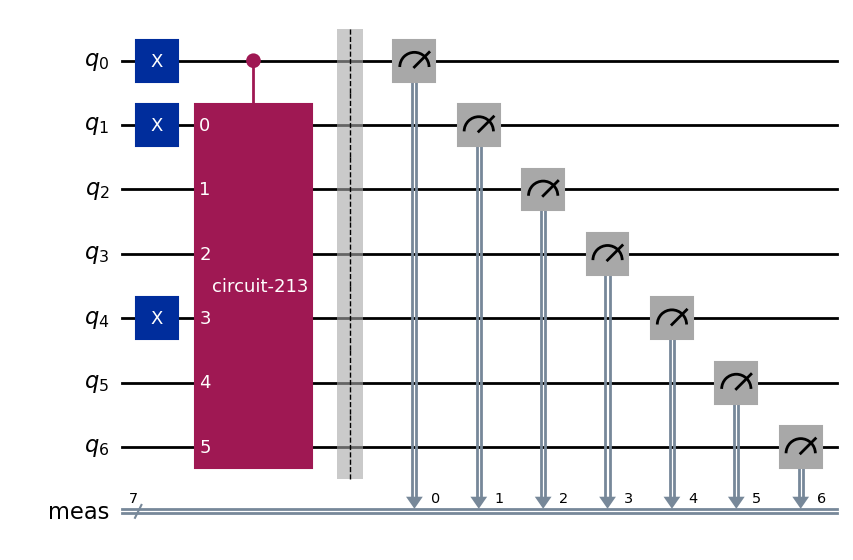

In [11]:
qc2 = QuantumCircuit(7)
qc2.x(0)
qc2.x(1)
qc2.x(4)
qc2.append(adder_circuit,[0,1,2,3,4,5,6])
qc2.measure_all()
qc2.draw('mpl')

Validating the Outputs from the Adder Circuit Block

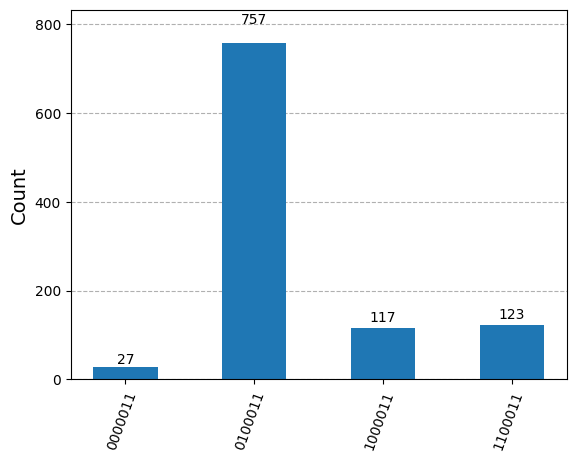

In [12]:
sim = Aer.get_backend('aer_simulator')
tqc2 = transpile(qc2,sim)
result = sim.run(tqc2).result()
counts = result.get_counts(tqc2)
plot_histogram(counts)

Multiplier Design using Adder Circuit Blocks

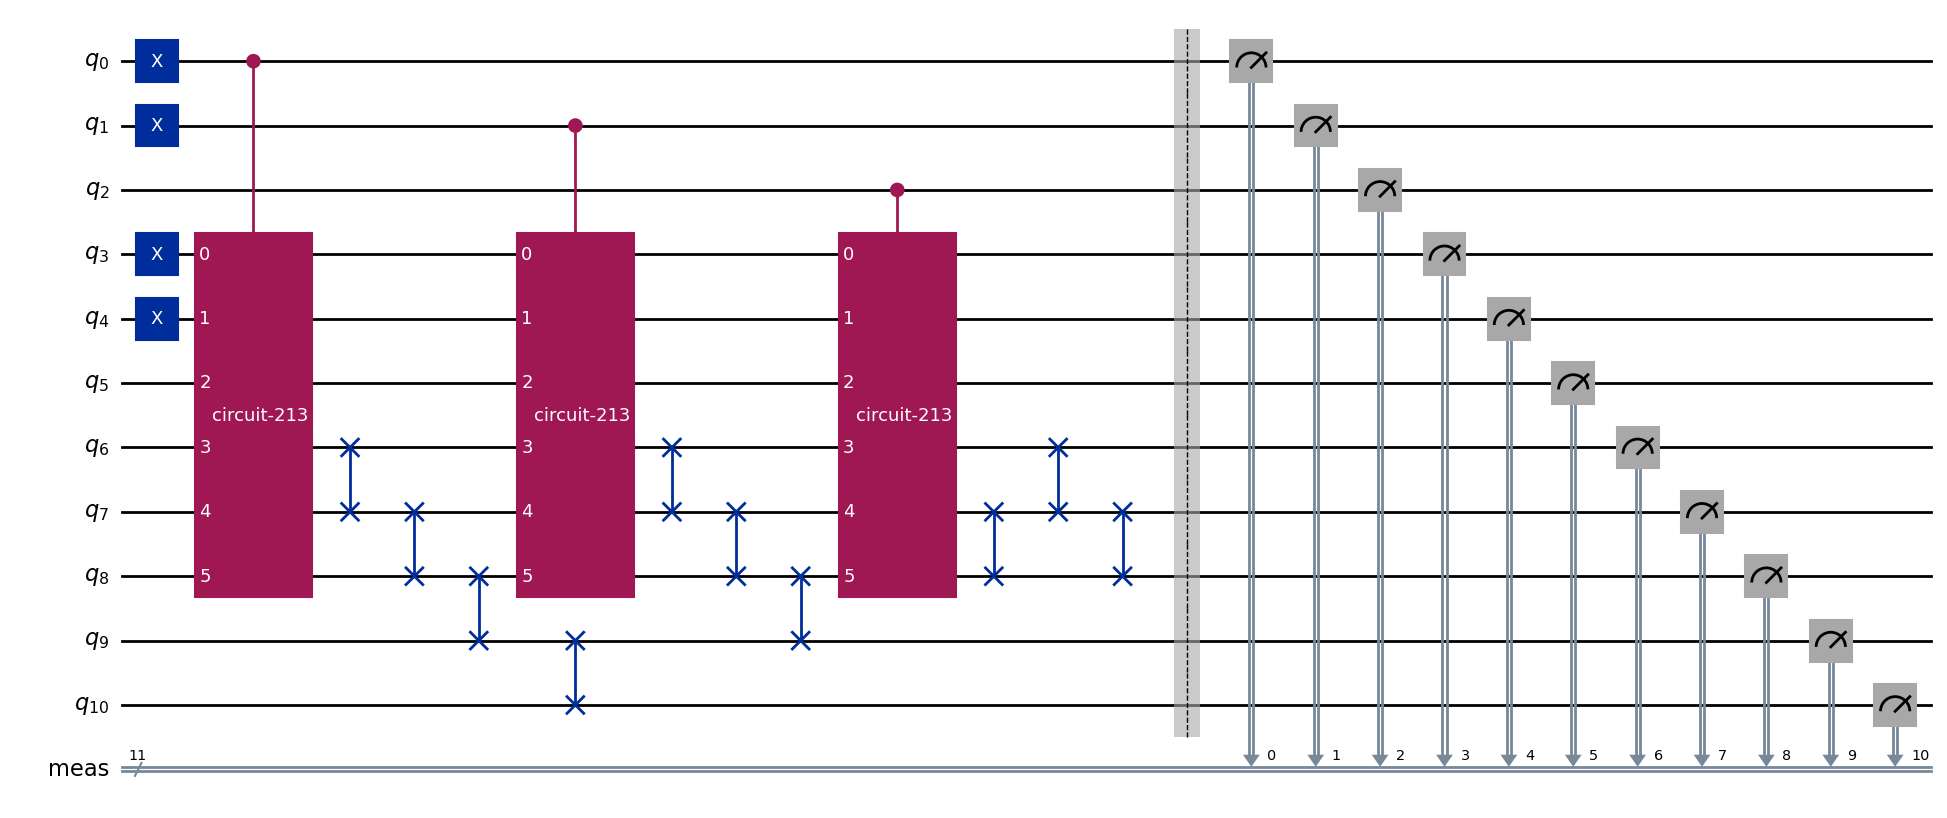

In [18]:

qc1 = QuantumCircuit(11)
qc1.x(0)
qc1.x(1)
qc1.x(3)
qc1.x(4)
#an input of 3 * 3 should give 9 or 1001 in the 5 lowest bits as output
qc1.append(adder_circuit,[0,3,4,5,6,7,8])
qc1.swap(6,7)
qc1.swap(7,8)
qc1.swap(8,9)
qc1.append(adder_circuit,[1,3,4,5,6,7,8])
qc1.swap(6,7)
qc1.swap(7,8)
qc1.swap(9,10)
qc1.swap(8,9)
qc1.append(adder_circuit,[2,3,4,5,6,7,8])
qc1.swap(7,8)
qc1.swap(6,7)
qc1.swap(7,8)
qc1.measure_all()
qc1.draw('mpl',fold = -1)



Validating Output of the Multiplier Circuit

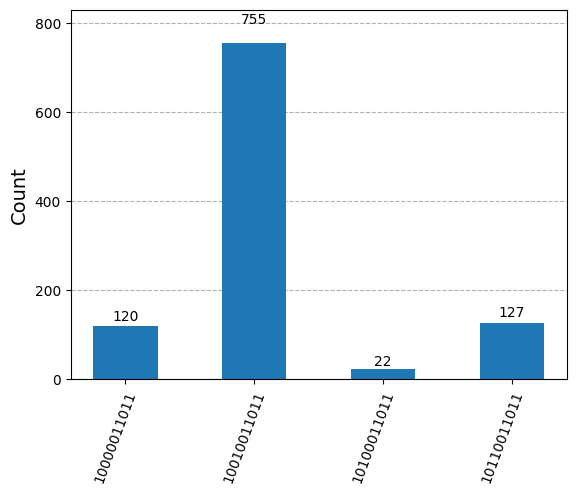

In [17]:

sim = Aer.get_backend('aer_simulator')
tqc1 = transpile(qc1,sim)
result = sim.run(tqc1).result()
counts = result.get_counts(tqc1)
plot_histogram(counts)